# EDA of Ship Images Dataset

This notebook consists of the EDA of the training data given

# Contents
Error Data
- [Statistics](#Error-Data-Statistics)
- [Image Dimension Distribution](#Error-data:-Image-Dimension-Distribution)

Train Data
- [Statistics](#Train-Data-Statistics)
- [Image Dimension Distribution](#Train-data:-Image-Dimension-Distribution)

In [22]:
import pandas as pd 
import matplotlib.pylab as plt
import seaborn as sns
# set as seaborn’s default theme
sns.set()
import glob     
import numpy as np
from PIL import Image
from collections import Counter
import sys
sys.path.append("..") # Adds higher directory to python modules path.
from pre_process_data import convert_all_images_from_png_to_jpg

In [70]:
TRAIN_SAMPLES = len(glob.glob("data/train/*.jpg"))

# Load the data path to images
TRAIN_IMG_DIR = '../data/train'
TRAIN_LABEL_FILENAME = 'labels.csv'

# Load the data path to error images
ERROR_IMG_DIR = '../data/error'
ERROR_LABEL_FILENAME = 'test_labels.csv'

# Error Data Statistics

No .png images found
The filename is test_labels.csv, however, there are no test samples
train_labels_df
            image  category
0     2810798.jpg         0
1     2818929.jpg         0
2     2856024.jpg         0
3     2878219.jpg         0
4     2841647.jpg         0
...           ...       ...
1995  2858050.jpg         4
1996  2886392.jpg         4
1997  2816858.jpg         4
1998  2845755.jpg         4
1999  2872187.jpg         4

[2000 rows x 2 columns]


Classes: [0 1 2 3 4]
Number of unique train labels: 2000


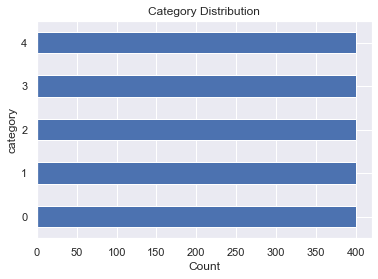

Number of train samples: 1000
Number of train labels: 2000
Print true if training_labels equate to the number of training samples:
False


There is a discrepancy in the training samples given and the 'test' labels in our csv. As such from this point on, we will only consider the subset distribution of the intersection of     both the training data dataframe and the training label dataframe as our complete training data
EDIT: It was found that this data was erroneous as such from this point forward, it will be labeled as error data


Train data
           image
0    1010906.jpg
1    1098729.jpg
2    1124945.jpg
3    1124951.jpg
4    1131196.jpg
..           ...
995   907105.jpg
996   921003.jpg
997   929280.jpg
998   929533.jpg
999   950585.jpg

[1000 rows x 1 columns]
intersection df
           image  category
0    2810798.jpg         0
1    2818929.jpg         0
2    2856024.jpg         0
3    2878219.jpg         0
4    2841647.jpg         0
..           ...       ...
995  2835366.jpg

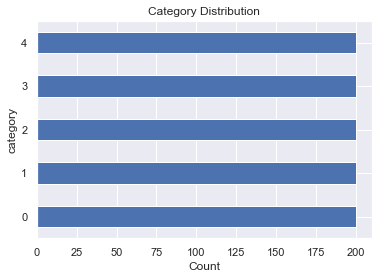

Since, the categories of the training set are equally distributed, a sampling strategy for training is not needed due to the lack of minority of and majority classes


In [71]:
convert_all_images_from_png_to_jpg(ERROR_IMG_DIR)

print("The filename is test_labels.csv, however, there are no test samples")

train_labels_df = pd.read_csv(f"{ERROR_IMG_DIR}/{ERROR_LABEL_FILENAME}")

print("train_labels_df")
print(train_labels_df)
print("\n")

classes = train_labels_df.category.unique()

print("Classes:", classes)
print("Number of unique train labels:", len(train_labels_df.image.unique()))

train_labels_df.groupby('category').size().plot.barh()
plt.title("Category Distribution")
plt.xlabel("Count")
plt.show()

print("Number of train samples:",len(glob.glob(f"{ERROR_IMG_DIR}/*.jpg")))

print("Number of train labels:", len(train_labels_df))

print("Print true if training_labels equate to the number of training samples:")
print(len(set(glob.glob(f"{ERROR_IMG_DIR}/*.jpg"))) == len(set(train_labels_df.image)))

print("\n")
print("There is a discrepancy in the training samples given and the 'test' labels in our csv. As such from this point on, we will only consider the subset distribution of the intersection of \
    both the training data dataframe and the training label dataframe as our complete training data")
print("EDIT: It was found that this data was erroneous as such from this point forward, it will be labeled as error data")
print("\n")

train_samples_df = pd.DataFrame([path.replace(f"{ERROR_IMG_DIR}\\","") for path in glob.glob(f"{ERROR_IMG_DIR}/*.jpg")],columns=['image'])
print("Train data")
print(train_samples_df)

int_df = pd.merge(train_labels_df, train_samples_df, how ='inner', on =['image'])
print("intersection df")
print(int_df)

int_df.groupby('category').size().plot.barh()
plt.title("Category Distribution")
plt.xlabel("Count")
plt.show()

print("Since, the categories of the training set are equally distributed, a sampling strategy for training is not needed due to the lack of minority of and majority classes")



# Error data: Image Dimension Distribution  

## What's the most common image size for all classes?


In [60]:
image_dimensions = []
image_dimensions_3d = []
for fn in glob.glob(f"{ERROR_IMG_DIR}/*.jpg"):
    im = Image.open(fn)
    arr = np.array(im)
    try:
        h,w,d = arr.shape
    except:
        h,w = arr.shape
        # value to indicate that the image is 2d
        d = 0
    image_dimensions.append((w,h))
    image_dimensions_3d.append((w,h,d))
image_shape_distribution = dict(Counter(image_dimensions))
image_3d_shape_distribution = dict(Counter(image_dimensions_3d))
print("Number of unique image (wxh) dimensions:",len(image_shape_distribution))
print("Number of unique image (wxhxd) dimensions:",len(image_3d_shape_distribution))

print("Note: that some images do not have a 3rd dimension of colour, this will be important edge case for the pipeline for pre-processing of images")

Number of unique image (wxh) dimensions: 98
Number of unique image (wxhxd) dimensions: 108
Note: that some images do not have a 3rd dimension of colour, this will be important edge case for the pipeline for pre-processing of images


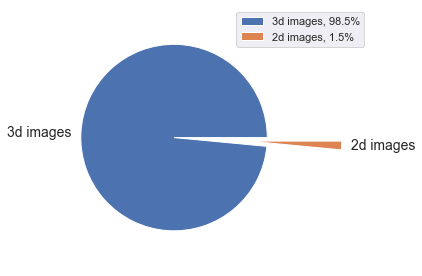

However, it is clear that the images are mostly 3d.


In [61]:
# Find all the number of images with no 3rd dimension
labels = ['3d images','2d images']
all_images = dict(Counter([i[2] for i in image_dimensions_3d]))
plt.pie(labels=labels, x=list(all_images.values()),explode=[0,0.8], textprops={'fontsize': 14})
labels = [f'{l}, {s/sum(all_images.values())*100:0.1f}%' for l, s in zip(labels, list(all_images.values()))]

plt.legend(labels, loc='best')
plt.axis('equal')
plt.tight_layout()
plt.show()

print("However, it is clear that the images are mostly 3d.")

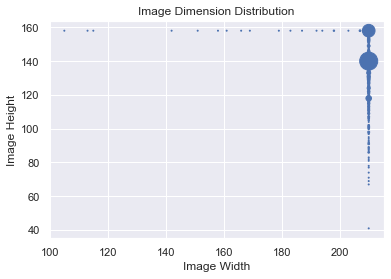

Top 3 dimensions out of 0 images
{'(210, 140)': 325, '(210, 158)': 160, '(210, 139)': 52}


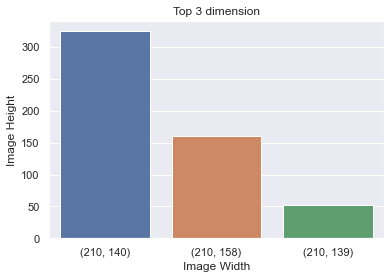

We see that a significant portion of images are 210 x 140 (weight x height), however, there would be a need to standardise the image data     input to ensure through an image function that biasedness towards predicting a boat type through the image type is     not learnt by the model


In [62]:
plt.scatter(
            x = [i[0] for i in image_shape_distribution.keys()], # Width 
            y = [i[1] for i in image_shape_distribution.keys()], # Height
            s = list(image_shape_distribution.values())           # Count
            )
plt.title("Image Dimension Distribution")
plt.xlabel("Image Width")
plt.ylabel("Image Height")
plt.show()

top_3_dimension = sorted(image_shape_distribution, key=image_shape_distribution.get, reverse=True)[:3]
sns.barplot(x = [str(i) for i in top_3_dimension], y= [image_shape_distribution[i] for i in top_3_dimension])
print("Top 3 dimensions out of {} images".format(TRAIN_SAMPLES))
print(dict(zip([str(i) for i in top_3_dimension],[image_shape_distribution[i] for i in top_3_dimension])))
plt.title("Top 3 dimension")
plt.xlabel("Image Width")
plt.ylabel("Image Height")
plt.show()

print("We see that a significant portion of images are 210 x 140 (weight x height), however, there would be a need to standardise the image data \
    input to ensure through an image function that biasedness towards predicting a boat type through the image type is \
    not learnt by the model")

# Train Data Statistics

No .png images found
train_labels_df
           image  category
0    2788353.jpg         0
1    2782131.jpg         0
2    2884349.jpg         0
3    2900596.jpg         0
4    2841543.jpg         0
..           ...       ...
895  2804619.jpg         4
896  2829250.jpg         4
897  2825240.jpg         4
898  2825172.jpg         4
899  2847678.jpg         4

[900 rows x 2 columns]


Classes: [0 1 2 3 4]
Number of unique train labels: 900


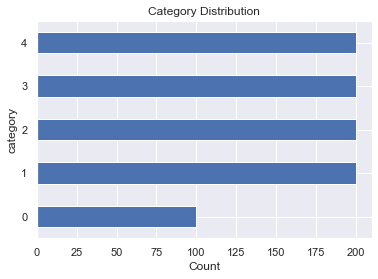

Number of train samples: 900
Number of train labels: 900
Print true if training_labels equate to the number of training samples:
True
Train data
           image
0    1003035.jpg
1    1005343.jpg
2    1008439.jpg
3    1015027.jpg
4    1056555.jpg
..           ...
895   964374.jpg
896   977738.jpg
897   980701.jpg
898   986137.jpg
899   997951.jpg

[900 rows x 1 columns]
intersection df
           image  category
0    2788353.jpg         0
1    2782131.jpg         0
2    2884349.jpg         0
3    2900596.jpg         0
4    2841543.jpg         0
..           ...       ...
895  2804619.jpg         4
896  2829250.jpg         4
897  2825240.jpg         4
898  2825172.jpg         4
899  2847678.jpg         4

[900 rows x 2 columns]


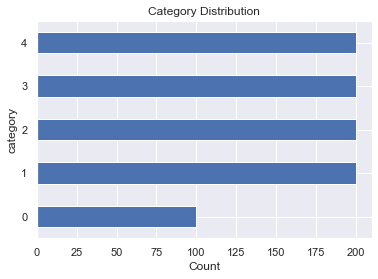



We are faced with some class imbalance in our training data as class 0 has 100 less samples than the other classes,
as such we will take note of this and apply a sampling strategy in our training phase
Due to the existence of a minority and majority class, this might lead to biases in the model that prevents it from generalizing class 0's ships as well as the other classes
Leading to an overprediction of the other classes other than 0.




In [63]:
convert_all_images_from_png_to_jpg(TRAIN_IMG_DIR)

train_labels_df = pd.read_csv(f"{TRAIN_IMG_DIR}/{TRAIN_LABEL_FILENAME}")

print("train_labels_df")
print(train_labels_df)
print("\n")

classes = train_labels_df.category.unique()

print("Classes:", classes)
print("Number of unique train labels:", len(train_labels_df.image.unique()))

train_labels_df.groupby('category').size().plot.barh()
plt.title("Category Distribution")
plt.xlabel("Count")
plt.show()

print("Number of train samples:",len(glob.glob(f"{TRAIN_IMG_DIR}/*.jpg")))

print("Number of train labels:", len(train_labels_df))

print("Print true if training_labels equate to the number of training samples:")
print(len(set(glob.glob(f"{TRAIN_IMG_DIR}/*.jpg"))) == len(set(train_labels_df.image)))

train_samples_df = pd.DataFrame([path.replace(f"{TRAIN_IMG_DIR}\\","") for path in glob.glob(f"{TRAIN_IMG_DIR}/*.jpg")],columns=['image'])
print("Train data")
print(train_samples_df)

int_df = pd.merge(train_labels_df, train_samples_df, how ='inner', on =['image'])
print("intersection df")
print(int_df)

int_df.groupby('category').size().plot.barh()
plt.title("Category Distribution")
plt.xlabel("Count")
plt.show()

print("\n")
print("We are faced with some class imbalance in our training data as class 0 has 100 less samples than the other classes,")
print("as such we will take note of this and apply a sampling strategy in our training phase")
print("Due to the existence of a minority and majority class, this might lead to biases in the model that prevents it from generalizing class 0's ships as well as the other classes")
print("Leading to an overprediction of the other classes other than 0.")
print("\n")


# Train data: Image Dimension Distribution  

## What's the most common image size for all classes?

In [64]:
image_dimensions = []
image_dimensions_3d = []
for fn in glob.glob(f"{TRAIN_IMG_DIR}/*.jpg"):
    im = Image.open(fn)
    arr = np.array(im)
    try:
        h,w,d = arr.shape
    except:
        h,w = arr.shape
        # value to indicate that the image is 2d
        d = 0
    image_dimensions.append((w,h))
    image_dimensions_3d.append((w,h,d))
image_shape_distribution = dict(Counter(image_dimensions))
image_3d_shape_distribution = dict(Counter(image_dimensions_3d))
print("Number of unique image (wxh) dimensions:",len(image_shape_distribution))
print("Number of unique image (wxhxd) dimensions:",len(image_3d_shape_distribution))

print("Note: that some images do not have a 3rd dimension of colour, this will be important edge case for the pipeline for pre-processing of images")

Number of unique image (wxh) dimensions: 98
Number of unique image (wxhxd) dimensions: 110
Note: that some images do not have a 3rd dimension of colour, this will be important edge case for the pipeline for pre-processing of images


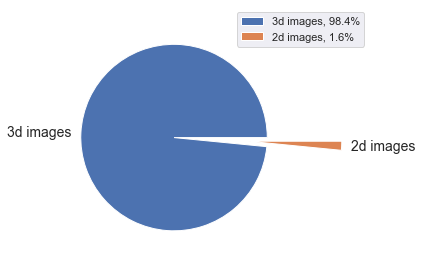

However, it is clear that the images are mostly 3d.


In [65]:
# Find all the number of images with no 3rd dimension
labels = ['3d images','2d images']
all_images = dict(Counter([i[2] for i in image_dimensions_3d]))
plt.pie(labels=labels, x=list(all_images.values()),explode=[0,0.8], textprops={'fontsize': 14})
labels = [f'{l}, {s/sum(all_images.values())*100:0.1f}%' for l, s in zip(labels, list(all_images.values()))]

plt.legend(labels, loc='best')
plt.axis('equal')
plt.tight_layout()
plt.show()

print("However, it is clear that the images are mostly 3d.")

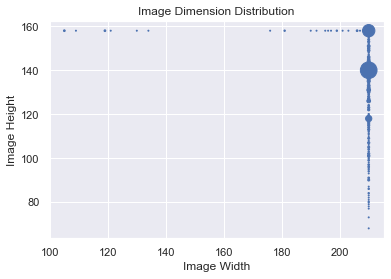

Top 3 dimensions out of 0 images
{'(210, 140)': 278, '(210, 158)': 152, '(210, 139)': 45}


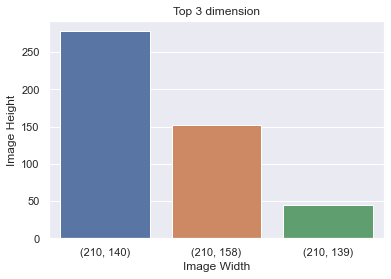

We see that a significant portion of images are 210 x 140 (weight x height), however, there would be a need to standardise the image data
input to ensure through an image function that biasedness towards predicting a certain boat type through the image type is not learnt by the model


In [68]:
plt.scatter(
            x = [i[0] for i in image_shape_distribution.keys()], # Width 
            y = [i[1] for i in image_shape_distribution.keys()], # Height
            s = list(image_shape_distribution.values())           # Count
            )
plt.title("Image Dimension Distribution")
plt.xlabel("Image Width")
plt.ylabel("Image Height")
plt.show()

top_3_dimension = sorted(image_shape_distribution, key=image_shape_distribution.get, reverse=True)[:3]
sns.barplot(x = [str(i) for i in top_3_dimension], y= [image_shape_distribution[i] for i in top_3_dimension])
print("Top 3 dimensions out of {} images".format(TRAIN_SAMPLES))
print(dict(zip([str(i) for i in top_3_dimension],[image_shape_distribution[i] for i in top_3_dimension])))
plt.title("Top 3 dimension")
plt.xlabel("Image Width")
plt.ylabel("Image Height")
plt.show()

print("We see that a significant portion of images are 210 x 140 (weight x height), however, there would be a need to standardise the image data")
print("input to ensure through an image function that biasedness towards predicting a certain boat type through the image type is not learnt by the model")